In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

### set up data

In [2]:
ts = pd.read_csv("data/flights.csv")

# prep
ts["date"] = pd.to_datetime(
    ts["year"].astype(str) + "-" + ts["month"].astype(str) + "-01"
)
ts["n"] = ts["passengers"]

import ta

ts["n_lag1"] = ts["n"].shift(1)
ts["n_lag3"] = ts["n"].shift(3)
ts["n_lag12"] = ts["n"].shift(12)
ts["ma12"] = ta.trend.sma_indicator(ts["n"], window=12, fillna=True)

ts.drop(columns=["year", "month"], inplace=True)

print(ts.head().to_string())
ts.shape

   passengers       date    n  n_lag1  n_lag3  n_lag12        ma12
0         112 1949-01-01  112     NaN     NaN      NaN  112.000000
1         118 1949-02-01  118   112.0     NaN      NaN  115.000000
2         132 1949-03-01  132   118.0     NaN      NaN  120.666667
3         129 1949-04-01  129   132.0   112.0      NaN  122.750000
4         121 1949-05-01  121   129.0   118.0      NaN  122.400000


(144, 7)

In [3]:
ts_g = (
    ts.assign(year=lambda x: x["date"].dt.year)
    .groupby(["year"], dropna=False, observed=False)
    .agg(
        **{
            "max_n": ("n", "max"),
            "max_n_date": (
                "n",
                lambda x: ts.loc[ts.loc[x.index, "n"].idxmax(), "date"],
            ),
            "min_n": ("n", "min"),
            "min_n_date": (
                "n",
                lambda x: ts.loc[ts.loc[x.index, "n"].idxmin(), "date"],
            ),
        }
    )
)
print(ts_g.head().to_string())

      max_n max_n_date  min_n min_n_date
year                                    
1949    148 1949-07-01    104 1949-11-01
1950    170 1950-07-01    114 1950-11-01
1951    199 1951-07-01    145 1951-01-01
1952    242 1952-08-01    171 1952-01-01
1953    272 1953-08-01    180 1953-11-01


### plot content

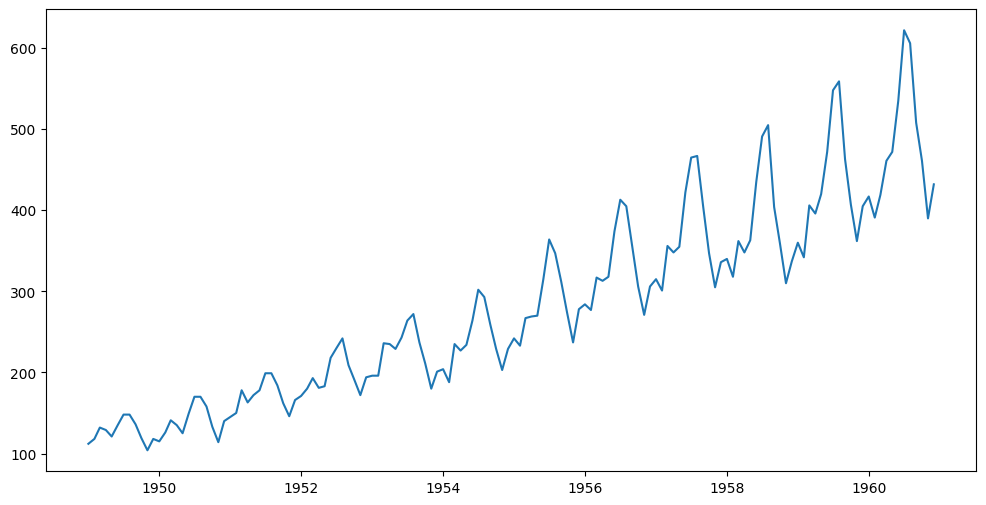

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts["date"], ts["n"])

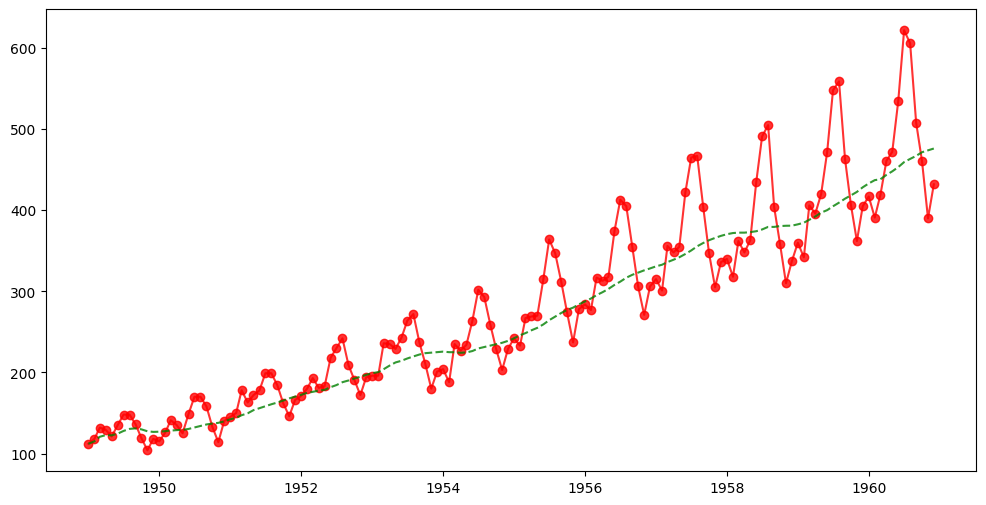

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    ts["date"], ts["n"], alpha=0.8, marker="o", color="red", label="Passenger Count"
)
ax.plot(
    ts["date"],
    ts["ma12"],
    alpha=0.8,
    color="green",
    linestyle="--",
    label="Passenger Count - 12 Month MA",
)
plt.close()
fig

### plot addons

In [7]:
# annotations
for i, row in ts_g.iterrows():
    ax.annotate(
        f"{row['max_n_date'].strftime('%Y-%m-%d')}",
        xy=(row["max_n_date"], row["max_n"]),
        xytext=(row["max_n_date"], row["max_n"] + 50),
        arrowprops=dict(arrowstyle="->", color="blue"),
        fontsize=9,
        color="blue",
    )
    ax.annotate(
        f"{row['min_n_date'].strftime('%Y-%m-%d')}",
        xy=(row["min_n_date"], row["min_n"]),
        xytext=(row["min_n_date"], row["min_n"] - 50),
        arrowprops=dict(arrowstyle="->", color="orange"),
        fontsize=9,
        color="orange",
    )

# axis formatting
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params("x", rotation=45)

ax.set_ylabel("Counts")
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

# title, legend, grid, spines, layout
ax.set_title(f"Passenger by time", fontsize=15, fontweight="bold")
ax.legend(loc="upper left", fontsize=10, frameon=False)
ax.grid(True, linestyle="--", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

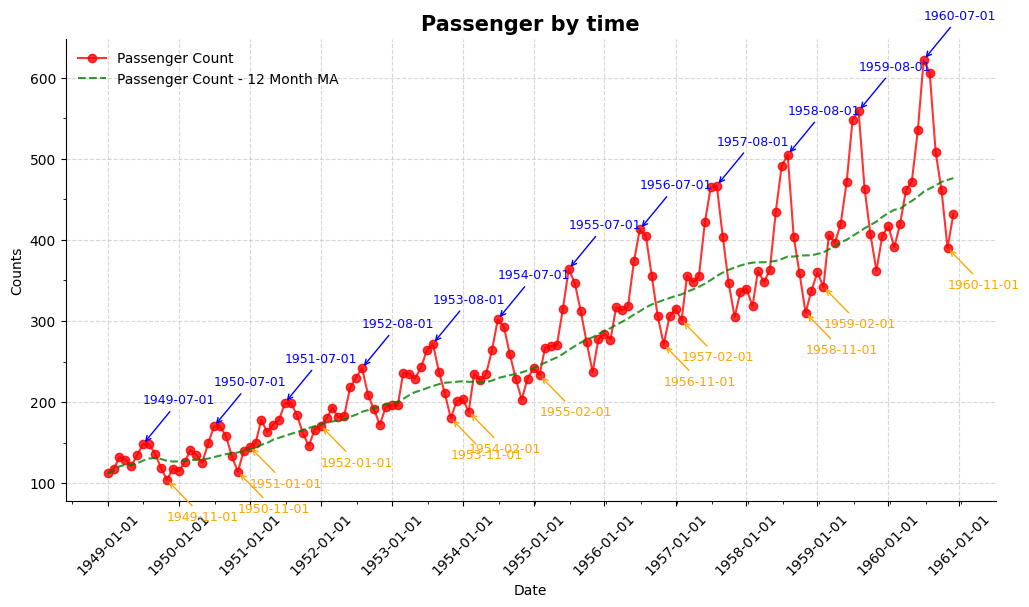

In [8]:
fig